In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm import tqdm

In [4]:
number_states = 4
sequence_length = 3
number_sequences = 1000
p_mutate = 1.0 / sequence_length
mean_error = -2 #mean of lognormal error distribution with sigma = .1
c = 1

In [5]:
# generate number of mutated states
number_mutated_states = np.random.binomial(sequence_length*number_sequences, p_mutate)
# generate positions of mutated states
position_ids = np.random.choice(sequence_length*number_sequences, number_mutated_states, replace=False)
positions = np.unravel_index(position_ids, (number_sequences, sequence_length))
# fill sparse matrix with 1s at positions of mutated states
sequences = sparse.csr_matrix((np.ones(number_mutated_states), positions), shape=(number_sequences, sequence_length), dtype=np.ubyte).toarray()
# replace 1s with random 8-bit integers
sequences[sequences == 1] = np.random.randint(1, number_states, sequences[sequences == 1].shape[0], dtype=np.ubyte) # ubyte is enough for 256 states
# we do this instead of the random choice above so the sequences are generated as 8-bit integers so large arrays can be stored in memory

# condense sequences to unique sequences and add counts as last column
sequences, counts = np.unique(sequences, axis=0, return_counts=True)

# remove sequences with counts below threshold c
sequences = sequences[counts >= c]
counts = counts[counts >= c]

In [6]:
print(sequences.shape)
print(counts.shape)

(56, 3)
(56,)


In [7]:
sequencing_error_rates = np.random.lognormal(mean_error, .1, sequence_length)
print(sequencing_error_rates)

[0.1249927  0.13213026 0.12603987]


In [8]:
def add_sequence_error(sequences, counts, sequencing_error_rates):
    
    full_sequences = np.repeat(sequences, np.maximum(counts, 0), axis=0)
    # add errors per position according to the error rates
    for i in range(full_sequences.shape[1]):
        # draw if error occurs
        error = np.random.binomial(1, sequencing_error_rates[i], full_sequences.shape[0])
        # draw the error as uniform over the states
        error_states = np.random.randint(1, number_states, full_sequences.shape[0], dtype=np.ubyte)
        # apply the error
        full_sequences[:, i] = full_sequences[:, i] * (1 - error) + error_states * error
    # make sequences unique
    sequences_with_errors, counts_with_errors = np.unique(full_sequences, axis=0, return_counts=True)

    sequences_with_errors_matched = []
    counts_matched = []

    #match the error sequences with the original sequences
    for seq in range(sequences.shape[0]):
        # find the matching sequences
        matching = np.where(np.all(sequences[seq] == sequences_with_errors, axis=1))[0]
        # if there are matching sequences, add them to the list
        if len(matching) > 0:
            sequences_with_errors_matched.append(sequences_with_errors[matching][0])
            counts_matched.append(counts_with_errors[matching][0])
        # if there are no matching sequences, add the original sequence with 0 counts
        else:
            sequences_with_errors_matched.append(sequences[seq])
            counts_matched.append(0)
    # convert to numpy arrays
    sequences_with_errors_matched = np.array(sequences_with_errors_matched)
    counts_matched = np.array(counts_matched)
            

    return sequences_with_errors, counts_with_errors, sequences_with_errors_matched, counts_matched
        

In [9]:
sequences_with_error, counts_with_error, sequences_with_errors_matched, counts_matched = add_sequence_error(sequences, counts, sequencing_error_rates)
print(sequences)
print(counts)
print(sequences_with_error)
print(counts_with_error)
print(sequences_with_errors_matched)
print(counts_matched)

[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 2 0]
 [0 2 1]
 [0 2 2]
 [0 2 3]
 [0 3 0]
 [0 3 1]
 [0 3 2]
 [0 3 3]
 [1 0 0]
 [1 0 1]
 [1 0 2]
 [1 0 3]
 [1 1 0]
 [1 1 1]
 [1 1 2]
 [1 1 3]
 [1 2 0]
 [1 2 1]
 [1 2 2]
 [1 3 0]
 [1 3 1]
 [1 3 2]
 [1 3 3]
 [2 0 0]
 [2 0 1]
 [2 0 2]
 [2 0 3]
 [2 1 0]
 [2 1 1]
 [2 1 2]
 [2 2 0]
 [2 2 3]
 [2 3 0]
 [2 3 1]
 [2 3 2]
 [2 3 3]
 [3 0 0]
 [3 0 1]
 [3 0 2]
 [3 0 3]
 [3 1 0]
 [3 1 1]
 [3 1 2]
 [3 1 3]
 [3 2 0]
 [3 2 3]
 [3 3 0]
 [3 3 3]]
[310  61  50  35  51  10   9   8  50   9  10   4  44  11   7   5  56  10
   2   8  13   3   1   2   6   1   1   8   1   1   2  45   7   9  10  13
   2   1  10   1   9   1   1   1  48   7   9   4   8   1   2   2  10   1
   8   1]
[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 2 0]
 [0 2 1]
 [0 2 2]
 [0 2 3]
 [0 3 0]
 [0 3 1]
 [0 3 2]
 [0 3 3]
 [1 0 0]
 [1 0 1]
 [1 0 2]
 [1 0 3]
 [1 1 0]
 [1 1 1]
 [1 1 2]
 [1 1 3]
 [1 2 0]
 [1 2 1]
 [1 2 2]
 [1 2 3]
 [1 3 0]
 [1 3

In [10]:
# check shape of counts and cpunts_matched
print(counts_matched.shape)
print(counts.shape)

(56,)
(56,)


In [11]:
print(sequencing_error_rates)

[0.1249927  0.13213026 0.12603987]


In [12]:
def transition_distribution(sequences, counts, sequencing_error_rates):
    # get the transition matrix
    transition_matrix = np.zeros((sequences.shape[0], sequences.shape[0]))
    for i in range(sequences.shape[0]):
        for j in range(sequences.shape[0]):
            if i == j:
                continue
            position_wise_probability = []
            for k in range(sequences.shape[1]):
                if sequences[i, k] != 0 and sequences[j, k] == 0:
                    position_wise_probability.append(sequencing_error_rates[k]/(number_states - 1))
                elif sequences[j, k] != 0 and sequences[i, k] != sequences[j, k]:
                    position_wise_probability.append(0)
                else:
                    continue
            # print(f"sequence {i} to sequence {j}: {position_wise_probability}")
            if len(position_wise_probability) == 0:
                transition_matrix[i, j] = 0
            else:
                transition_matrix[i, j] = np.prod(position_wise_probability)

    # set diagonal to (1 - sum of row)
    transition_matrix = transition_matrix + np.diag(1 - np.sum(transition_matrix, axis=1))

    transition_counts = np.dot(counts/np.sum(counts), transition_matrix)

    transition_counts = np.round(transition_counts*np.sum(counts)).astype(int)

    return transition_counts

In [13]:
transition_counts = transition_distribution(sequences_with_errors_matched, counts_matched, sequencing_error_rates)
print(counts_matched)
print(transition_counts)
print(counts)

[212  49  45  36  49  21  10  12  48  14  13   9  46  10  12   5  50  16
  11  10  21   4   2   1   8   2   1  11   1   3   4  40  11  14  12  12
   2   3  12   3  12   0   2   2  45  13  15  10  10   2   1   0  12   1
  14   1]
[230  51  46  37  50  19   9  11  49  13  12   8  47   9  11   5  51  15
  10   9  19   3   2   1   7   2   1  10   1   3   3  41  10  13  11  11
   2   3  11   3  11   0   2   2  46  12  14   9   9   2   1   0  11   1
  13   1]
[310  61  50  35  51  10   9   8  50   9  10   4  44  11   7   5  56  10
   2   8  13   3   1   2   6   1   1   8   1   1   2  45   7   9  10  13
   2   1  10   1   9   1   1   1  48   7   9   4   8   1   2   2  10   1
   8   1]


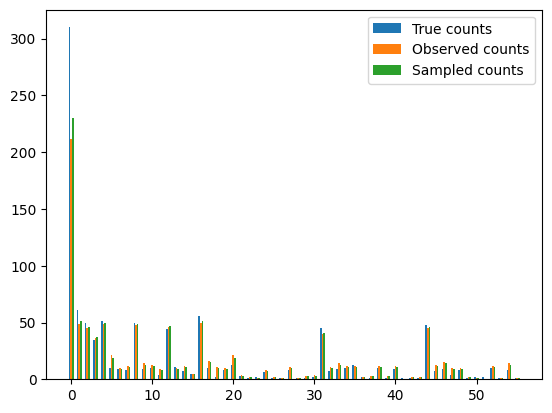

In [14]:
# bar plot the true counts, the observed counts and the sampled counts
plt.bar(np.arange(counts.shape[0]) - 0.2, counts, width=0.2, label="True counts")
plt.bar(np.arange(counts_matched.shape[0]) + 0.0, counts_matched, width=0.2, label="Observed counts")
plt.bar(np.arange(transition_counts.shape[0]) + 0.2, transition_counts, width=0.2, label="Sampled counts")
plt.legend()
plt.show()

In [15]:
# find a initial count distribution that if the error function is applied to it repeatedly, it will consistently match the observed error distribution
# the initial count distribution should be a random distribution that is not too far from the observed distribution

def sample_initial_distribution(sequences, counts, sequencing_error_rates, n_iter=10000):
    # initial parameters are the observed counts
    parameters = counts
    candidates = []
    best_kl = np.inf
    best_counts = parameters
    kl_list = []
    # apply the error function to the initial distribution
    for i in range(n_iter):
        sequences_with_error, counts_with_error, sequences_with_errors_matched, counts_matched = add_sequence_error(sequences, parameters, sequencing_error_rates)

        # compute KL divergence
        kl = stats.entropy(counts, counts_matched)
        kl_list.append(kl)
        # if the KL divergence is smaller than the best KL divergence, update the best KL divergence
        if kl < best_kl:
            best_kl = kl
            best_counts = parameters
        # update the initial distribution
        parameters = np.maximum(0,parameters + (counts - counts_matched) + np.random.randint(-2, 2, counts.shape))
        candidates.append(parameters)

    # check that weights don't sum to 0
    if np.sum(1/(np.array(kl_list)+1)) == 0:
        return kl_list, best_counts, candidates
    mean_parameters = np.round(np.average(candidates, axis=0, weights=1/(np.array(kl_list)+1))).astype(int)
    
    return kl_list, mean_parameters, candidates

    

In [16]:
print("true counts:", counts)
print("observed counts:", counts_matched)
# find the initial distribution
kl_divs, mean_parameters, paramters = sample_initial_distribution(sequences, counts_matched, sequencing_error_rates)
# get weighted average of the parameters, weighted by the KL divergence
print("inferred counts:", mean_parameters)

true counts: [310  61  50  35  51  10   9   8  50   9  10   4  44  11   7   5  56  10
   2   8  13   3   1   2   6   1   1   8   1   1   2  45   7   9  10  13
   2   1  10   1   9   1   1   1  48   7   9   4   8   1   2   2  10   1
   8   1]
observed counts: [212  49  45  36  49  21  10  12  48  14  13   9  46  10  12   5  50  16
  11  10  21   4   2   1   8   2   1  11   1   3   4  40  11  14  12  12
   2   3  12   3  12   0   2   2  45  13  15  10  10   2   1   0  12   1
  14   1]
inferred counts: [318  51  46  32  50  21   5   9  48  11  10   5  45   6   9   1  53  14
   7   6  21   2   0   0   3   1   0   7   0   2   3  38   7  12  10   8
   0   2   9   2   9   0   1   1  45  10  13   7   5   0   0   0   9   0
  12   0]


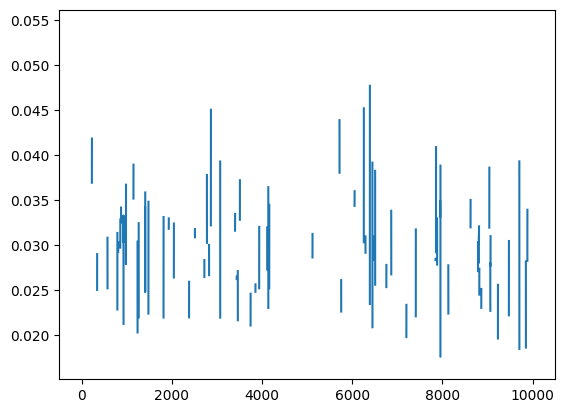

In [17]:
# plot the KL divergence over the iterations
plt.plot(kl_divs)
plt.show()

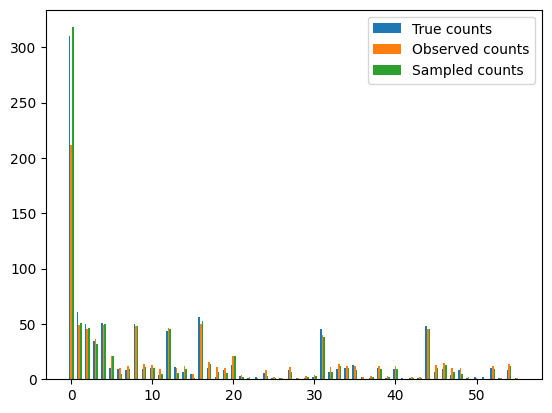

In [18]:
# bar plot the true counts, the observed counts and the sampled counts
plt.bar(np.arange(counts.shape[0]) - 0.2, counts, width=0.2, label="True counts")
plt.bar(np.arange(counts_matched.shape[0]) + 0.0, counts_matched, width=0.2, label="Observed counts")
plt.bar(np.arange(mean_parameters.shape[0]) + 0.2, mean_parameters, width=0.2, label="Sampled counts")
plt.legend()
plt.show()

In [19]:
def full_inversion(sequences, counts, sequencing_error_rates, p_mutate):
    # initial transition matrix
    transition_matrix = np.zeros((sequences.shape[0], sequences.shape[0]))
    # fill the transition matrix with the number of different elements in the sequences
    for i in range(sequences.shape[0]):
        for j in range(sequences.shape[0]):
            if i == j:
                continue
            position_wise_probability = []
            for k in range(sequences.shape[1]):
                if sequences[i, k] != sequences[j, k]:
                    position_wise_probability.append(sequencing_error_rates[k]/(number_states - 1))
                else:
                    position_wise_probability.append(1 - sequencing_error_rates[k])
            transition_matrix[i, j] = np.prod(position_wise_probability)

    # set diagonal to (1 - sum of row)
    transition_matrix = transition_matrix + np.diag(1 - np.sum(transition_matrix, axis=1))
    # print(np.min(transition_matrix))
    # print(np.sum(transition_matrix, axis=1))

    # check if matrix is invertible
    # if np.linalg.matrix_rank(transition_matrix) < transition_matrix.shape[0]:
        # print("Matrix is not invertible")
        # return None

    # compute the inverse transition matrix
    inverse_transition_matrix = np.linalg.inv(transition_matrix)

    # normalize counts
    counts_norm = counts / np.sum(counts)
    # print(counts_norm)
    # compute the full inversion
    full_inversion = np.dot(counts_norm, inverse_transition_matrix)
    # print(full_inversion)

    # # make sure the full inversion is positive
    # full_inversion = np.maximum(0, full_inversion)

    # # normalize the full inversion
    # full_inversion = full_inversion / np.sum(full_inversion)

    #scale and round the full inversion
    full_inversion = np.round(full_inversion * np.sum(counts)).astype(int)
    # set minimum count to 0
    full_inversion = np.maximum(0, full_inversion)

    return full_inversion
#TODO something here is wrong, applying the inversion gives negative counts/probabilities

In [20]:
print("true counts:", counts)
print("observed counts:", counts_matched)

# compute the full inversion
full_inversion_counts = full_inversion(sequences, counts_matched, sequencing_error_rates, p_mutate)
print("full inversion counts:", full_inversion_counts)

true counts: [310  61  50  35  51  10   9   8  50   9  10   4  44  11   7   5  56  10
   2   8  13   3   1   2   6   1   1   8   1   1   2  45   7   9  10  13
   2   1  10   1   9   1   1   1  48   7   9   4   8   1   2   2  10   1
   8   1]
observed counts: [212  49  45  36  49  21  10  12  48  14  13   9  46  10  12   5  50  16
  11  10  21   4   2   1   8   2   1  11   1   3   4  40  11  14  12  12
   2   3  12   3  12   0   2   2  45  13  15  10  10   2   1   0  12   1
  14   1]
full inversion counts: [299  51  45  32  49  23   6  10  48  11  11   6  46   6  10   0  53  16
   8   7  24   2   0   0   3   1   0   8   0   2   4  37   8  13  11   9
   0   2  10   2  11   0   0   1  45  10  14   8   6   0   0   0   9   0
  12   0]


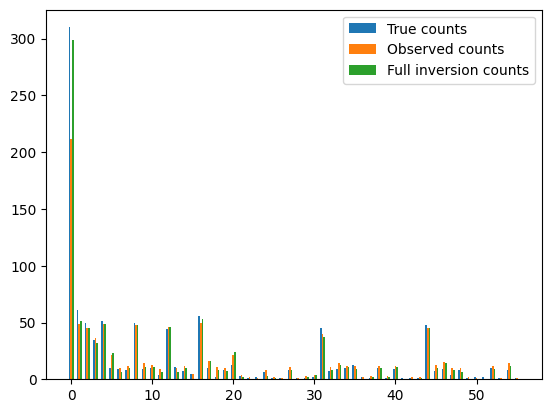

In [21]:
# bar plot the true counts, the observed counts and the full inversion counts
plt.bar(np.arange(counts.shape[0]) - 0.2, counts, width=0.2, label="True counts")
plt.bar(np.arange(counts_matched.shape[0]) + 0.0, counts_matched, width=0.2, label="Observed counts")
plt.bar(np.arange(full_inversion_counts.shape[0]) + 0.2, full_inversion_counts, width=0.2, label="Full inversion counts")
plt.legend()
plt.show()

In [22]:
def partial_inversion(sequences, counts, sequencing_error_rates, p_mutate):

    full_sequences = np.repeat(sequences, np.round(counts).astype(int), axis=0)

    # normalize the counts
    counts_norm = counts / np.sum(counts)

    # intialize state probabilities
    state_counts = np.zeros((number_states, sequences.shape[1]))
    # fill state probabilities with the observed counts
    for i in range(number_states):
        for j in range(sequences.shape[1]):
            state_counts[i, j] = np.sum(full_sequences[:, j] == i)

    # print(state_counts)

    counts_partial_inversion = np.zeros(counts.shape)

    for seq in range(sequences.shape[0]):
        # compute state counts without the current sequence
        state_counts_without_seq = state_counts.copy()
        for i in range(sequences.shape[1]):
            for j in range(number_states):
                if sequences[seq, i] == j:
                    state_counts_without_seq[j, i] -= counts[seq]
            
        # compute the state probabilities without the current sequence
        state_probs_without_seq = state_counts_without_seq / np.sum(state_counts_without_seq, axis=0)

        # compute the probability of the current sequence not transitioning
        prob_no_transition = np.prod(1 - sequencing_error_rates)

        # compute the probability of all other sequences transitioning to the current sequence
        for pos in range(sequences.shape[1]):
            for state in range(number_states):
                if state != sequences[seq, pos]:
                    state_probs_without_seq[state, pos] = state_probs_without_seq[state, pos] * (sequencing_error_rates[pos] / (number_states - 1))
                else:
                    state_probs_without_seq[state, pos] = state_probs_without_seq[state, pos] * (1 - sequencing_error_rates[pos])

        prob_transition = np.prod(np.sum(state_probs_without_seq, axis=0))

        # create the partial transition matrix
        partial_transition_matrix = np.array([[prob_no_transition, 1-prob_no_transition], [prob_transition, 1-prob_transition]])
        
        # invert the partial transition matrix
        inverse_partial_transition_matrix = np.linalg.inv(partial_transition_matrix)

        # compute the partial inversion
        partial_inversion = np.dot([counts[seq], 1 - counts[seq]], inverse_partial_transition_matrix)
        counts_partial_inversion[seq] = partial_inversion[0]

    # normalize counts
    counts_partial_inversion = counts_partial_inversion / np.sum(counts_partial_inversion)
    # scale and round the partial inversion
    counts_partial_inversion = np.round(counts_partial_inversion*np.sum(counts)).astype(int)
    # # make all counts positive
    # counts_partial_inversion = np.maximum(1, counts_partial_inversion)

    return counts_partial_inversion


In [23]:
partial_inversion_counts = partial_inversion(sequences, counts_matched, sequencing_error_rates, p_mutate)
print("true counts:", counts)
print("observed counts:", counts_matched)
print("partial inversion counts:", partial_inversion_counts)

true counts: [310  61  50  35  51  10   9   8  50   9  10   4  44  11   7   5  56  10
   2   8  13   3   1   2   6   1   1   8   1   1   2  45   7   9  10  13
   2   1  10   1   9   1   1   1  48   7   9   4   8   1   2   2  10   1
   8   1]
observed counts: [212  49  45  36  49  21  10  12  48  14  13   9  46  10  12   5  50  16
  11  10  21   4   2   1   8   2   1  11   1   3   4  40  11  14  12  12
   2   3  12   3  12   0   2   2  45  13  15  10  10   2   1   0  12   1
  14   1]
partial inversion counts: [232  49  45  35  49  20  10  11  47  13  12   9  45  10  11   5  50  15
  11  10  20   4   2   1   8   2   1  11   1   3   4  40  11  13  11  12
   2   3  11   3  11   0   2   2  44  12  14  10  10   2   1   0  11   1
  13   1]


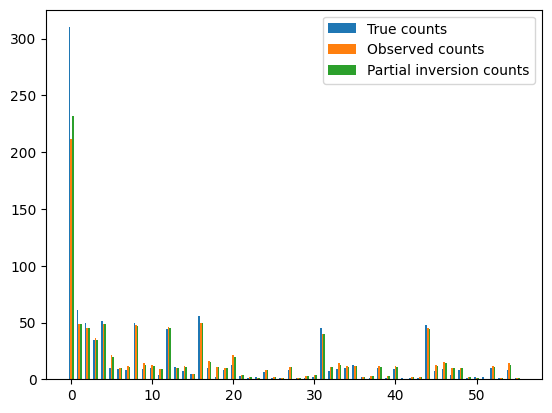

In [24]:
# bar plot the true counts, the observed counts and the partial inversion counts
plt.bar(np.arange(counts.shape[0]) - 0.2, counts, width=0.2, label="True counts")
plt.bar(np.arange(counts_matched.shape[0]) + 0.0, counts_matched, width=0.2, label="Observed counts")
plt.bar(np.arange(partial_inversion_counts.shape[0]) + 0.2, partial_inversion_counts, width=0.2, label="Partial inversion counts")
plt.legend()
plt.show()

In [25]:
# check if kl divergence of observed and true counts or sampled and true counts is smaller
kl_true_observed = stats.entropy(counts, counts_matched + 1e-10)
kl_true_sampled = stats.entropy(counts, mean_parameters + 1e-10)
kl_full_inversion_true = stats.entropy(counts, full_inversion_counts + 1e-10)
kl_partial_inversion_true = stats.entropy(counts, partial_inversion_counts + 1e-10)
print(f"KL divergence of true and observed counts: {kl_true_observed}")
print(f"KL divergence of true and sampled counts: {kl_true_sampled}")
print(f"KL divergence of true and full inversion counts: {kl_full_inversion_true}")
print(f"KL divergence of true and partial inversion counts: {kl_partial_inversion_true}")

KL divergence of true and observed counts: 0.12382267315880655
KL divergence of true and sampled counts: 0.3622513090098669
KL divergence of true and full inversion counts: 0.503217885490959
KL divergence of true and partial inversion counts: 0.11134960914583109


In [26]:
# function for testing all 3 methods
def test_methods(number_sequences : int, sequence_length : int, number_states : int, p_mutate : float, mean_error : float, c : int, n_iter : int):
    # generate number of mutated states
    number_mutated_states = np.random.binomial(sequence_length*number_sequences, p_mutate)
    # generate positions of mutated states
    position_ids = np.random.choice(sequence_length*number_sequences, number_mutated_states, replace=False)
    positions = np.unravel_index(position_ids, (number_sequences, sequence_length))
    # fill sparse matrix with 1s at positions of mutated states
    sequences = sparse.csr_matrix((np.ones(number_mutated_states), positions), shape=(number_sequences, sequence_length), dtype=np.ubyte).toarray()
    # replace 1s with random 8-bit integers
    sequences[sequences == 1] = np.random.randint(1, number_states, sequences[sequences == 1].shape[0], dtype=np.ubyte) # ubyte is enough for 256 states
    # we do this instead of the random choice above so the sequences are generated as 8-bit integers so large arrays can be stored in memory

    # condense sequences to unique sequences and add counts as last column
    sequences, counts = np.unique(sequences, axis=0, return_counts=True)

    # remove sequences with counts below threshold c
    sequences = sequences[counts >= c]
    counts = counts[counts >= c]

    sequencing_error_rates = np.random.lognormal(mean_error, .1, sequence_length)

    # add sequencing error to the sequences
    sequences_with_error, counts_with_error, sequences_with_errors_matched, counts_matched = add_sequence_error(sequences, counts, sequencing_error_rates)

    # test transition distribution method
    transition_counts = transition_distribution(sequences_with_errors_matched, counts_matched, sequencing_error_rates)

    # test sampling method
    ml_counts, median_counts, kl_list = sample_initial_distribution(sequences, counts_matched, sequencing_error_rates, n_iter)

    # test full inversion method
    full_inversion_counts = full_inversion(sequences, counts_matched, sequencing_error_rates, p_mutate)

    # test partial inversion method
    partial_inversion_counts = partial_inversion(sequences, counts_matched, sequencing_error_rates, p_mutate)

    # compute KL divergences
    kl_true_observed = stats.entropy(counts, counts_matched + 1e-10)
    kl_true_transitions = stats.entropy(counts, transition_counts + 1e-10)
    kl_true_sampled = stats.entropy(counts, median_counts + 1e-10)
    kl_full_inversion_true = stats.entropy(counts, full_inversion_counts + 1e-10)
    kl_partial_inversion_true = stats.entropy(counts, partial_inversion_counts + 1e-10)

    return kl_true_observed, kl_true_transitions, kl_true_sampled, kl_full_inversion_true, kl_partial_inversion_true

In [27]:
#fucntion to test the methods multiple times with different parameters
def test_multiple_times(n_tests : int, path : str):
    # open file to write results
    with open(path, "w") as f:
        f.write("id, number_sequences, sequence_length, p_mutate, max_error, n_iter, kl_true_observed, kl_true_transitions, kl_true_sampled, kl_full_inversion_true, kl_partial_inversion_true\n")
    # loop over all tests
    for i in tqdm(range(n_tests)):
        # generate random parameters
        number_sequences = np.random.randint(1000, 100000)
        sequence_length = np.random.randint(5, 20)
        number_states = 4
        p_mutate = np.random.uniform(0.05, 0.2)
        mean_error = np.random.uniform(-6, -2)
        c = np.round(np.random.randint(1, number_sequences/100)).astype(int)
        n_iter = np.random.randint(10000, 20000)
        # test the methods
        kl_true_observed, kl_true_transitions, kl_true_sampled, kl_full_inversion_true, kl_partial_inversion_true = test_methods(number_sequences, sequence_length, number_states, p_mutate, mean_error, c, n_iter)
        # write results to file
        with open(path, "a") as f:
            f.write(f"{i}, {number_sequences}, {sequence_length}, {p_mutate}, {np.exp(mean_error+0.1/2)}, {n_iter}, {kl_true_observed}, {kl_true_transitions}, {kl_true_sampled}, {kl_full_inversion_true}, {kl_partial_inversion_true}\n")
    # close file
    f.close()
    print("Done after", n_tests, "tests")


In [28]:
test_multiple_times(1000, "../data/error_test/test_long2.csv")

  0%|          | 2/1000 [13:11<119:16:31, 430.25s/it]/tmp/ipykernel_5292/2675283646.py:28: RuntimeWarning: invalid value encountered in divide
  state_probs_without_seq = state_counts_without_seq / np.sum(state_counts_without_seq, axis=0)
/tmp/ipykernel_5292/2675283646.py:56: RuntimeWarning: invalid value encountered in cast
  counts_partial_inversion = np.round(counts_partial_inversion*np.sum(counts)).astype(int)
  7%|▋         | 70/1000 [10:13:59<135:57:21, 526.28s/it]


KeyboardInterrupt: 

In [29]:
# read the results from the file
import pandas as pd

df = pd.read_csv("../data/error_test/test_long2.csv")


print(df.shape)
print(df.head())

(70, 11)
   id   number_sequences   sequence_length   p_mutate   max_error   n_iter  \
0   0              24272                 7   0.120456    0.046022    12740   
1   1              46851                11   0.096515    0.030812    14832   
2   2              41444                16   0.179754    0.003931    17635   
3   3              37925                11   0.168472    0.005148    12758   
4   4               3113                11   0.184044    0.045010    14849   

    kl_true_observed   kl_true_transitions   kl_true_sampled  \
0           0.013232              0.010679          0.000419   
1           0.009101              0.007534          0.000396   
2           0.000000              0.000000          0.000000   
3           0.000114              0.000086          0.000063   
4           0.011456              0.009608          0.008453   

    kl_full_inversion_true   kl_partial_inversion_true  
0                 0.003938                    0.001593  
1                 0.006

In [30]:
# get column names
columns = df.columns
print(columns)

Index(['id', ' number_sequences', ' sequence_length', ' p_mutate',
       ' max_error', ' n_iter', ' kl_true_observed', ' kl_true_transitions',
       ' kl_true_sampled', ' kl_full_inversion_true',
       ' kl_partial_inversion_true'],
      dtype='object')


In [31]:
# replace " inf" with nan
df = df.replace(" inf", np.nan)
# make columns numbers
df[columns[1:]] = df[columns[1:]].apply(pd.to_numeric)

<Axes: >

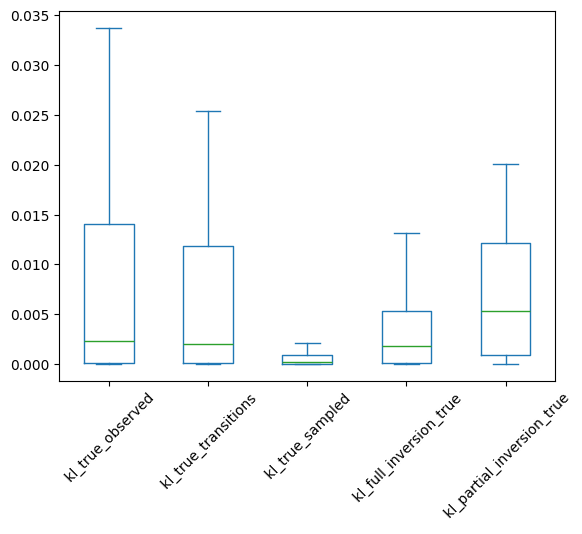

In [32]:
# boxplot of the KL divergences with 45 degree rotation
df.plot.box(y=columns[6:], showfliers=False, rot=45)

/home/joshua/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


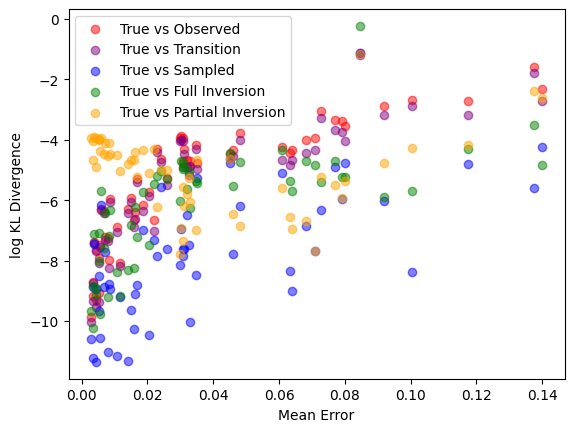

In [33]:
# plot max_error vs kl divergence with the kl divergence as color
plt.scatter(df[" max_error"], np.log(df[" kl_true_observed"]), color="red", label="True vs Observed", alpha=0.5)
plt.scatter(df[" max_error"], np.log(df[" kl_true_transitions"]), color="purple", label="True vs Transition", alpha=0.5)
plt.scatter(df[" max_error"], np.log(df[" kl_true_sampled"]), color="blue", label="True vs Sampled", alpha=0.5)
plt.scatter(df[" max_error"], np.log(df[" kl_full_inversion_true"]), color="green", label="True vs Full Inversion", alpha=0.5)
plt.scatter(df[" max_error"], np.log(df[" kl_partial_inversion_true"]), color="orange", label="True vs Partial Inversion", alpha=0.5)


plt.xlabel("Mean Error")
plt.ylabel("log KL Divergence")
plt.legend()
plt.show()


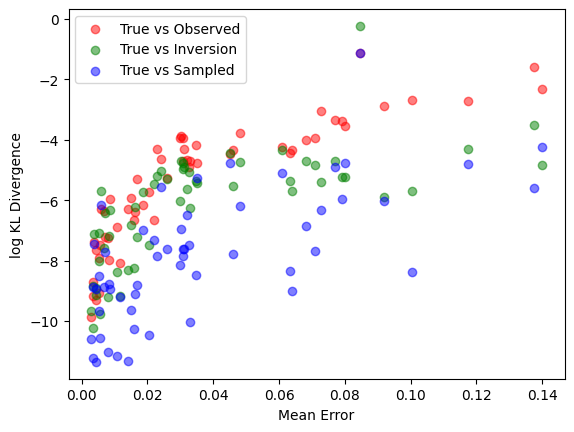

In [34]:
# plot max_error vs kl divergence with the kl divergence as color
plt.scatter(df[" max_error"], np.log(df[" kl_true_observed"]), color="red", label="True vs Observed", alpha=0.5)
plt.scatter(df[" max_error"], np.log(df[" kl_full_inversion_true"]), color="green", label="True vs Inversion", alpha=0.5)
plt.scatter(df[" max_error"], np.log(df[" kl_true_sampled"]), color="blue", label="True vs Sampled", alpha=0.5)
# plt.scatter(df[" max_error"], np.log(df[" kl_full_inversion_true"]), color="green", label="True vs Full Inversion", alpha=0.5)
# plt.scatter(df[" max_error"], np.log(df[" kl_partial_inversion_true"]), color="orange", label="True vs Partial Inversion", alpha=0.5)


plt.xlabel("Mean Error")
plt.ylabel("log KL Divergence")
plt.legend()
plt.show()

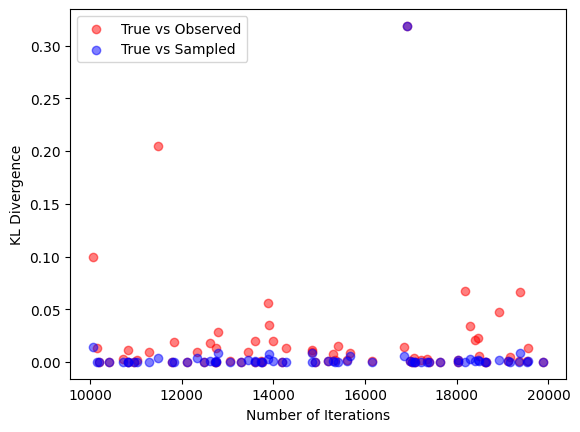

In [35]:
# plot n_iter vs  kl_true_sampled
plt.scatter(df[" n_iter"], df[" kl_true_observed"], color="red", label="True vs Observed", alpha=0.5)
plt.scatter(df[" n_iter"], df[" kl_true_sampled"], color="blue", label="True vs Sampled", alpha=0.5)
plt.xlabel("Number of Iterations")
plt.ylabel("KL Divergence")
plt.legend()
plt.show()

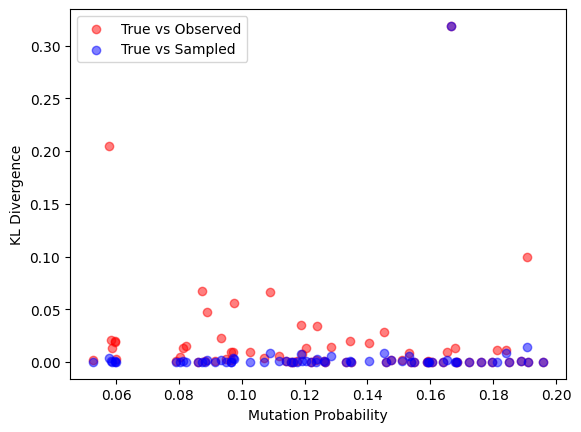

In [36]:
# plot p_mutate vs  kl_true_sampled
plt.scatter(df[" p_mutate"], df[" kl_true_observed"], color="red", label="True vs Observed", alpha=0.5)
plt.scatter(df[" p_mutate"], df[" kl_true_sampled"], color="blue", label="True vs Sampled", alpha=0.5)
plt.xlabel("Mutation Probability")
plt.ylabel("KL Divergence")
plt.legend()
plt.show()

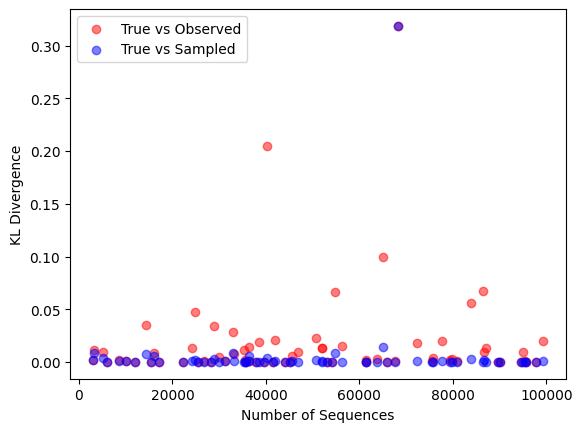

In [37]:
# plot number_sequences vs  kl_true_sampled
plt.scatter(df[" number_sequences"], df[" kl_true_observed"], color="red", label="True vs Observed", alpha=0.5)
plt.scatter(df[" number_sequences"], df[" kl_true_sampled"], color="blue", label="True vs Sampled", alpha=0.5)
plt.xlabel("Number of Sequences")
plt.ylabel("KL Divergence")
plt.legend()
plt.show()

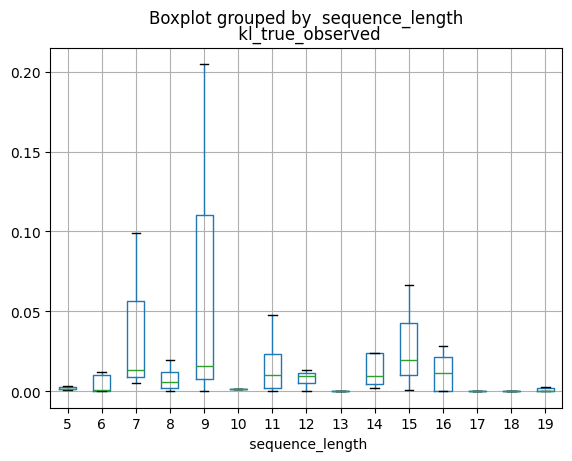

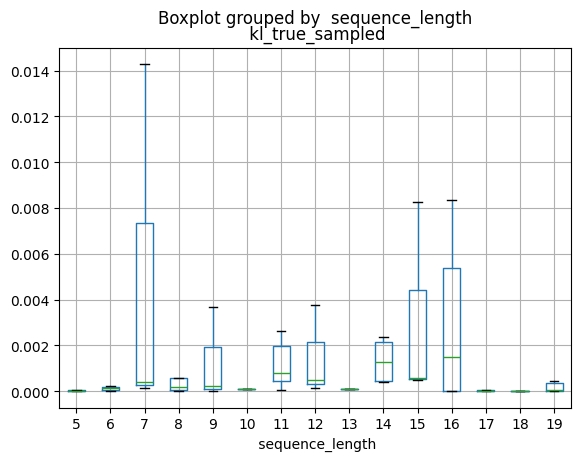

In [38]:
# box plot kl_true_observed for different sequence lengths
df.boxplot(column=" kl_true_observed", by=" sequence_length", showfliers=False)
# plt.ylim(0, 5)
df.boxplot(column=" kl_true_sampled", by=" sequence_length", showfliers=False)
# make y axis scale identical
# plt.ylim(0, 5)
plt.show()